<a href="https://colab.research.google.com/github/WilfriKusnadi/superduperimageanalysis/blob/main/analyze_drops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python numpy matplotlib scipy


STAGE 1: Drop Detection & Labeling
Upload your drop image:


Saving temp (1).jpg to temp (1) (1).jpg
Processing: temp (1) (1).jpg
Image dimensions: 3301 x 2550
Total contours detected: 394
Creating diagnostic visualization of ALL detected contours...
Diagnostic: Drew circles around 394 detected contours


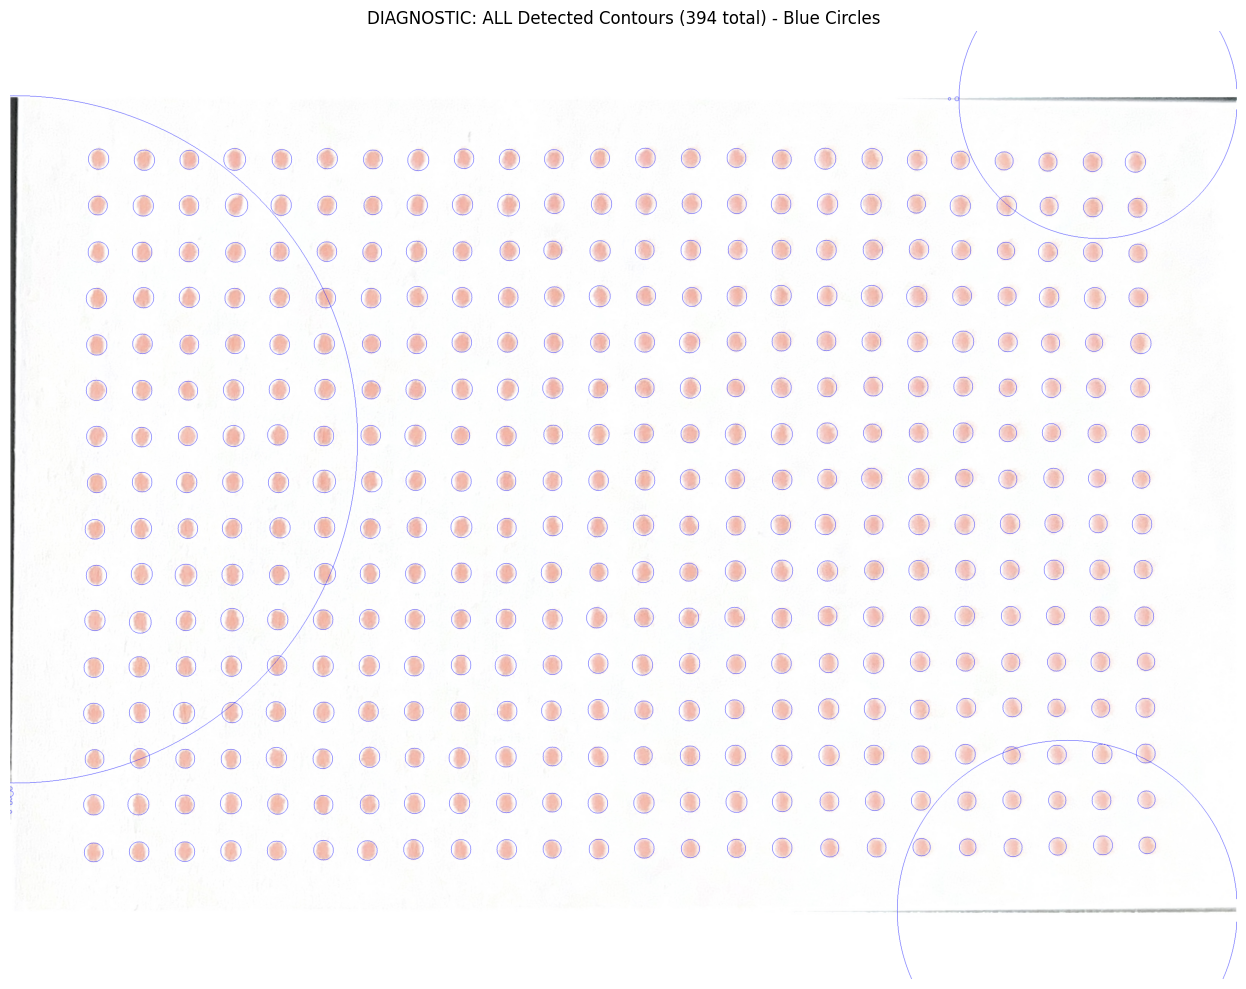


PHASE 2: CORRECTED FILTERING AND RANKING
Step 1: Calculate shape properties and coordinates...
After shape calculation: 394 candidates
Step 2: Edge filtering...
After edge filtering: 388 candidates
Step 3: Proximity filtering...
After proximity filtering: 388 candidates
Step 4: Rank by perimeter deviation from median...
Median perimeter: 144.9 pixels
Selected 384 drops with smallest perimeter deviation
Deviation range: 0.0 to 22.7

FILTERING SUMMARY:
  Initial contours: 394
  After edge filter: 388
  After proximity filter: 388
  Final selection: 384 drops

PHASE 3: GRID ASSIGNMENT

PHASE 4: VISUALIZATION AND OUTPUT
Displaying results...


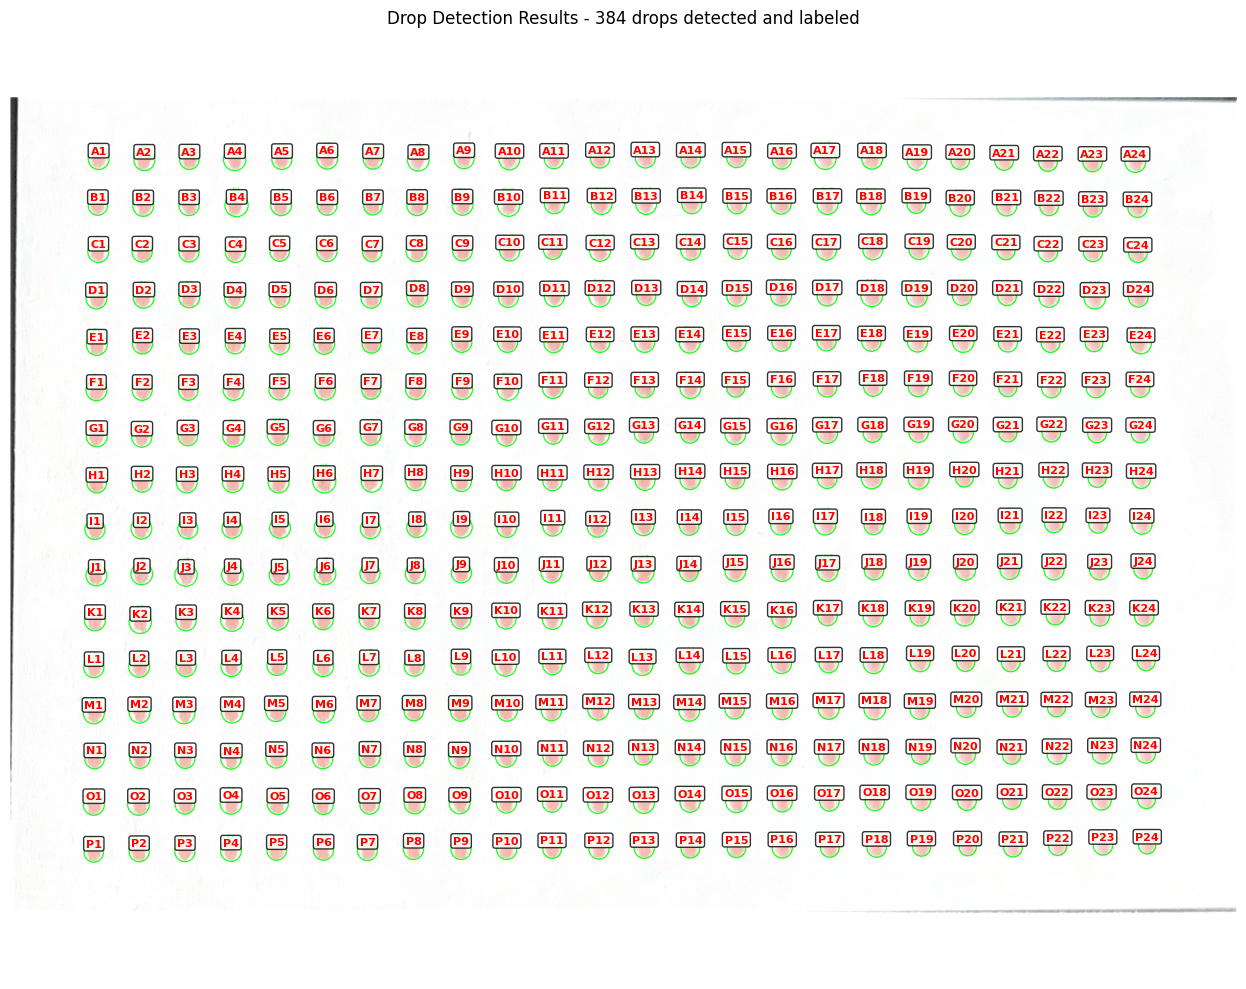

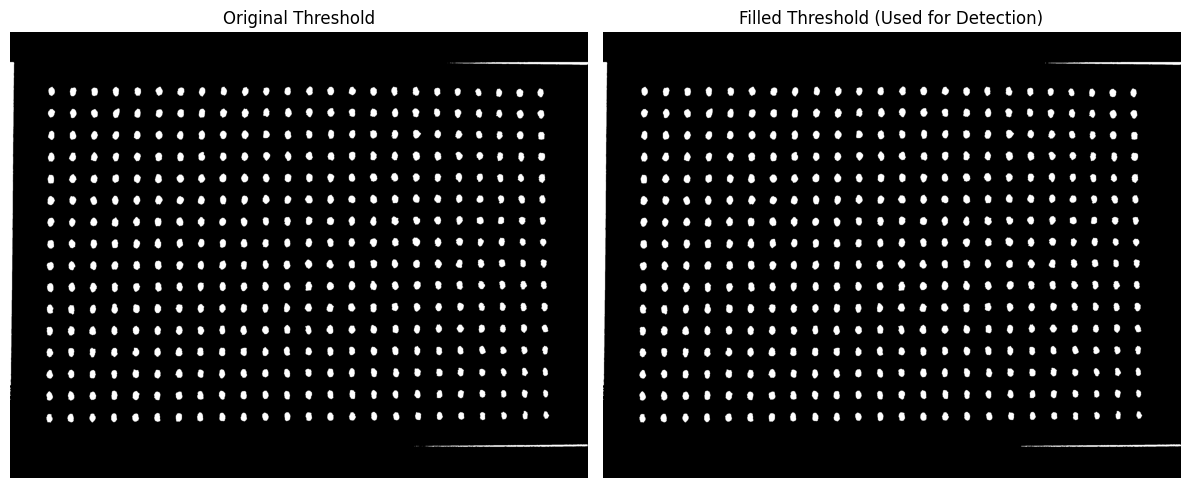


Detected 384 drops

Drop Analysis Results:


,Drop ID,X (px),Y (px),Area (px²),Perimeter (px),Perimeter Deviation,Circularity,Diameter (px)
0,A1,238.0,344.0,1347.5,145.0,0.0,0.806,41.4
1,A2,361.0,347.0,1403.5,147.6,2.7,0.809,42.3
2,A3,482.3,346.5,1372.5,143.2,1.8,0.842,41.8
3,A4,604.5,345.5,1415.5,150.1,5.2,0.789,42.5
4,A5,731.5,345.1,1347.5,146.5,1.5,0.789,41.4
...,...,...,...,...,...,...,...,...
379,P20,2576.0,2195.0,1117.5,131.6,13.3,0.810,37.7
380,P21,2698.9,2196.5,1056.0,132.6,12.4,0.755,36.7
381,P22,2818.9,2193.7,981.0,125.4,19.5,0.784,35.3
382,P23,2940.1,2190.9,1017.0,140.2,4.7,0.650,36.0



SUMMARY STATISTICS
Median Perimeter: 144.9 px
Average Area: 1325.5 ± 103.9 px²
Average Perimeter: 144.7 ± 5.6 px
Average Perimeter Deviation: 4.2 ± 3.7 px
Average Circularity: 0.795 ± 0.036
Average Diameter: 41.0 ± 1.6 px

STAGE 1 COMPLETE
Successfully detected and labeled: 384 drops
Grid range: A1 to P24
Results saved to: drop_detection_results_20250822_235209.pkl


In [4]:
from google.colab import files
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import pandas as pd
import string
from IPython.display import display, HTML
import io
import base64
import pickle
import json
from datetime import datetime

print("STAGE 1: Drop Detection & Labeling")
print("="*50)

# Upload image
print("Upload your drop image:")
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
print(f"Processing: {image_path}")

# Read image
image = cv2.imread(image_path)
original_image = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
height, width = gray.shape

print(f"Image dimensions: {width} x {height}")

# Enhanced drop detection with filled contours
blur = cv2.GaussianBlur(gray, (5, 5), 0)
_, gray_thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Apply morphological operations to fill holes and connect components
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
# Fill holes inside drops
filled_thresh = cv2.morphologyEx(gray_thresh, cv2.MORPH_CLOSE, kernel, iterations=2)
# Fill any remaining holes
filled_thresh = cv2.morphologyEx(filled_thresh, cv2.MORPH_OPEN, kernel, iterations=1)

# Find contours using filled threshold
contours, _ = cv2.findContours(filled_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Total contours detected: {len(contours)}")

# DIAGNOSTIC: Show ALL detected contours before any filtering
print("Creating diagnostic visualization of ALL detected contours...")
diagnostic_image = original_image.copy()

diagnostic_count = 0
for cnt in contours:
    area = cv2.contourArea(cnt)
    if area >= 1:  # Very minimal filter just to avoid zero-area artifacts
        (x, y), radius = cv2.minEnclosingCircle(cnt)

        # Calculate proper circle radius based on contour dimensions
        max_distance = 0
        center_x, center_y = int(x), int(y)
        for point in cnt:
            px, py = point[0]
            distance = np.sqrt((px - center_x)**2 + (py - center_y)**2)
            max_distance = max(max_distance, distance)

        circle_radius = int(max_distance) + 2
        circle_radius = max(circle_radius, 3)  # Minimum 3 pixels for visibility

        # Draw blue circle for ALL detections
        cv2.circle(diagnostic_image, (center_x, center_y), circle_radius, (255, 0, 0), 1)  # Blue circles
        diagnostic_count += 1

print(f"Diagnostic: Drew circles around {diagnostic_count} detected contours")

# Display diagnostic image
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(diagnostic_image, cv2.COLOR_BGR2RGB))
plt.title(f'DIAGNOSTIC: ALL Detected Contours ({diagnostic_count} total) - Blue Circles')
plt.axis("off")
plt.tight_layout()
plt.show()

# CORRECTED PHASE 2: FILTERING AND RANKING
print("\n" + "="*50)
print("PHASE 2: CORRECTED FILTERING AND RANKING")
print("="*50)

# Step 1: Calculate shape properties and coordinates
print("Step 1: Calculate shape properties and coordinates...")
candidates = []

for i, cnt in enumerate(contours):
    area = cv2.contourArea(cnt)
    if area < 3:  # Very minimal filtering
        continue

    perimeter = cv2.arcLength(cnt, True)
    if perimeter == 0:
        continue

    (x, y), radius = cv2.minEnclosingCircle(cnt)

    # Calculate shape properties
    circularity = 4 * np.pi * area / (perimeter * perimeter) if perimeter > 0 else 0

    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = area / hull_area if hull_area > 0 else 0

    rect = cv2.minAreaRect(cnt)
    w, h = rect[1]
    aspect_ratio = max(w, h) / min(w, h) if min(w, h) > 0 else float('inf')

    x_rect, y_rect, w_rect, h_rect = cv2.boundingRect(cnt)
    extent = area / (w_rect * h_rect) if (w_rect * h_rect) > 0 else 0

    candidates.append({
        'contour': cnt,
        'area': area,
        'perimeter': perimeter,
        'circularity': circularity,
        'solidity': solidity,
        'aspect_ratio': aspect_ratio,
        'extent': extent,
        'x': x,
        'y': y,
        'radius': radius
    })

print(f"After shape calculation: {len(candidates)} candidates")

# Step 2: Edge filtering
print("Step 2: Edge filtering...")
margin = 60  # 60 pixel margin from edges
edge_filtered = []

for candidate in candidates:
    x, y = candidate['x'], candidate['y']
    if x >= margin and y >= margin and x <= width - margin and y <= height - margin:
        edge_filtered.append(candidate)

print(f"After edge filtering: {len(edge_filtered)} candidates")

# Step 3: Proximity filtering
print("Step 3: Proximity filtering...")
min_distance = 20  # 20 pixel minimum distance between centers

proximity_filtered = []
for candidate in edge_filtered:
    too_close = False

    # Check distance against all already accepted drops
    for existing in proximity_filtered:
        dist = np.sqrt((candidate['x'] - existing['x'])**2 + (candidate['y'] - existing['y'])**2)
        if dist < min_distance:
            too_close = True
            break

    if not too_close:
        proximity_filtered.append(candidate)

print(f"After proximity filtering: {len(proximity_filtered)} candidates")

# Step 4: Rank by perimeter deviation from median and select top 384
print("Step 4: Rank by perimeter deviation from median...")

if len(proximity_filtered) > 0:
    # Calculate median perimeter
    perimeters = [drop['perimeter'] for drop in proximity_filtered]
    median_perimeter = np.median(perimeters)
    print(f"Median perimeter: {median_perimeter:.1f} pixels")

    # Calculate deviation from median for each drop
    for drop in proximity_filtered:
        drop['perimeter_deviation'] = abs(drop['perimeter'] - median_perimeter)

    # Sort by smallest deviation from median (best drops first)
    proximity_filtered.sort(key=lambda x: x['perimeter_deviation'])

    # Select top 384 (or all available if fewer)
    final_drop_count = min(384, len(proximity_filtered))
    selected_384_drops = proximity_filtered[:final_drop_count]

    print(f"Selected {len(selected_384_drops)} drops with smallest perimeter deviation")
    print(f"Deviation range: {selected_384_drops[0]['perimeter_deviation']:.1f} to {selected_384_drops[-1]['perimeter_deviation']:.1f}")
else:
    selected_384_drops = []
    print("No drops found after filtering!")

print(f"\nFILTERING SUMMARY:")
print(f"  Initial contours: {len(candidates)}")
print(f"  After edge filter: {len(edge_filtered)}")
print(f"  After proximity filter: {len(proximity_filtered)}")
print(f"  Final selection: {len(selected_384_drops)} drops")

# GRID ASSIGNMENT (unchanged)
print("\n" + "="*50)
print("PHASE 3: GRID ASSIGNMENT")
print("="*50)

# Step 1: Get x,y coordinates of each drop's center point
drop_centers = []
for drop in selected_384_drops:
    drop_centers.append({
        'x': drop['x'],
        'y': drop['y'],
        'drop_data': drop  # Keep reference to original drop
    })

# Step 2: Sort by Y coordinate (lowest Y = Row A)
drop_centers.sort(key=lambda d: d['y'])  # Lowest Y first

# Step 3: Group into exactly 16 rows of 24 drops each
labeled_drops = []

for row_idx in range(16):
    # Get 24 drops for this row (or remaining drops)
    start_idx = row_idx * 24
    end_idx = min(start_idx + 24, len(drop_centers))

    if start_idx >= len(drop_centers):
        break

    row_drops = drop_centers[start_idx:end_idx]

    # Step 4: Sort this row by X coordinate (lowest X first)
    row_drops.sort(key=lambda d: d['x'])  # Lowest X first, highest X last

    # Step 5: Assign labels A1, A2, ..., A24
    row_letter = chr(ord('A') + row_idx)  # A, B, C, ..., P

    for col_idx, drop_center in enumerate(row_drops):
        drop_center['drop_data']['label'] = f"{row_letter}{col_idx + 1}"
        labeled_drops.append(drop_center['drop_data'])

# VISUALIZATION AND OUTPUT (unchanged)
print("\n" + "="*50)
print("PHASE 4: VISUALIZATION AND OUTPUT")
print("="*50)

result_image = original_image.copy()

for drop in labeled_drops:
    # Get contour and center
    contour = drop['contour']
    center_x, center_y = int(drop['x']), int(drop['y'])

    # Calculate minimum radius to contain all contour pixels
    max_distance = 0
    for point in contour:
        px, py = point[0]
        distance = np.sqrt((px - center_x)**2 + (py - center_y)**2)
        max_distance = max(max_distance, distance)

    # Circle radius: minimum needed to contain all pixels + small buffer
    circle_radius = int(max_distance) + 2
    circle_radius = max(circle_radius, 5)  # Minimum 5 pixels for visibility

    # Draw green circle around drop
    cv2.circle(result_image, (center_x, center_y), circle_radius, (0, 255, 0), 2)

    # Add label above the circle
    label_text = drop['label']

    # Calculate text position (centered above circle)
    text_size = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)[0]
    label_x = center_x - text_size[0] // 2
    label_y = center_y - circle_radius - 5

    # Draw label text
    cv2.putText(result_image, label_text,
                (label_x, label_y),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,           # Font size
                (0, 255, 0),   # Green color
                1,             # Thickness
                cv2.LINE_AA)   # Anti-aliased

# Process data for output
drop_data = []
for drop in labeled_drops:
    diameter = 2 * np.sqrt(drop['area'] / np.pi)
    drop_data.append({
        'label': drop['label'],
        'x': drop['x'],
        'y': drop['y'],
        'area': drop['area'],
        'perimeter': drop['perimeter'],
        'perimeter_deviation': drop['perimeter_deviation'],
        'circularity': drop['circularity'],
        'diameter': diameter
    })

# Create DataFrame
df = pd.DataFrame(drop_data)
if not df.empty:
    df.columns = ['Drop ID', 'X (px)', 'Y (px)', 'Area (px²)', 'Perimeter (px)', 'Perimeter Deviation', 'Circularity', 'Diameter (px)']

    # Round numerical values
    df['Area (px²)'] = df['Area (px²)'].round(1)
    df['Perimeter (px)'] = df['Perimeter (px)'].round(1)
    df['Perimeter Deviation'] = df['Perimeter Deviation'].round(1)
    df['Circularity'] = df['Circularity'].round(3)
    df['Diameter (px)'] = df['Diameter (px)'].round(1)
    df['X (px)'] = df['X (px)'].round(1)
    df['Y (px)'] = df['Y (px)'].round(1)

# Save detection results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_filename = f"drop_detection_results_{timestamp}.pkl"

detection_results = {
    'labeled_drops': labeled_drops,
    'image_path': image_path,
    'image_dimensions': (width, height),
    'median_perimeter': np.median([d['perimeter'] for d in labeled_drops]) if labeled_drops else 0,
    'detection_summary': {
        'total_detected': len(labeled_drops),
        'detection_timestamp': timestamp,
        'algorithm_version': 'perimeter_deviation_v1',
        'max_drops_targeted': 384
    }
}

with open(results_filename, 'wb') as f:
    pickle.dump(detection_results, f)

# Display results with labels
print("Displaying results...")
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.title(f'Drop Detection Results - {len(labeled_drops)} drops detected and labeled')

# Add labels to each drop on the plot
for drop in labeled_drops:
    plt.text(drop['x'], drop['y']-10, drop['label'],
             color='red', fontsize=8, fontweight='bold',
             ha='center', va='bottom',
             bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))

plt.axis("off")
plt.tight_layout()
plt.show()

# Show both thresholds for debugging
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].imshow(gray_thresh, cmap='gray')
axes[0].set_title('Original Threshold')
axes[0].axis('off')

axes[1].imshow(filled_thresh, cmap='gray')
axes[1].set_title('Filled Threshold (Used for Detection)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Display data table
if not df.empty:
    print(f"\nDetected {len(labeled_drops)} drops")
    print("\nDrop Analysis Results:")
    display(df)

    # Summary statistics
    print(f"\n" + "="*50)
    print("SUMMARY STATISTICS")
    print("="*50)
    print(f"Median Perimeter: {np.median([d['perimeter'] for d in labeled_drops]):.1f} px")
    print(f"Average Area: {df['Area (px²)'].mean():.1f} ± {df['Area (px²)'].std():.1f} px²")
    print(f"Average Perimeter: {df['Perimeter (px)'].mean():.1f} ± {df['Perimeter (px)'].std():.1f} px")
    print(f"Average Perimeter Deviation: {df['Perimeter Deviation'].mean():.1f} ± {df['Perimeter Deviation'].std():.1f} px")
    print(f"Average Circularity: {df['Circularity'].mean():.3f} ± {df['Circularity'].std():.3f}")
    print(f"Average Diameter: {df['Diameter (px)'].mean():.1f} ± {df['Diameter (px)'].std():.1f} px")

print(f"\nSTAGE 1 COMPLETE")
print(f"Successfully detected and labeled: {len(labeled_drops)} drops")
if labeled_drops:
    print(f"Grid range: {labeled_drops[0]['label']} to {labeled_drops[-1]['label']}")
print(f"Results saved to: {results_filename}")

In [5]:
import pickle
import pandas as pd
import numpy as np
import string
from IPython.display import display, HTML
import base64
from datetime import datetime

print("STAGE 2: Analysis & Export")
print("="*50)

# Load detection results
print("Load detection results from Stage 1:")

# Try to find the most recent file
try:
    results_filename = input("Enter the results filename from Stage 1 (press Enter for most recent): ").strip()
    if not results_filename:
        import glob
        import os
        files = glob.glob("drop_detection_results_*.pkl")
        if files:
            results_filename = max(files, key=os.path.getctime)
            print(f"Using most recent file: {results_filename}")
        else:
            raise FileNotFoundError("No detection results found")
except:
    print("ERROR: Could not load detection results. Please run Stage 1 first.")
    exit()

# Load the data
try:
    with open(results_filename, 'rb') as f:
        detection_results = pickle.load(f)

    labeled_drops = detection_results['labeled_drops']
    image_path = detection_results['image_path']
    detection_summary = detection_results['detection_summary']

    print(f"Loaded: {detection_summary['total_detected']} drops from {image_path}")

except Exception as e:
    print(f"ERROR loading file: {e}")
    exit()

# Volume Input System
def get_volume_assignments(labeled_drops):
    """Interactive system to assign volumes to rows"""

    if not labeled_drops:
        return {}

    # Get all unique rows
    rows = sorted(list(set([drop['label'][0] for drop in labeled_drops])))
    print(f"\nVolume Assignment for Analysis")
    print(f"Detected rows: {', '.join(rows)} (Total: {len(rows)} rows)")

    print("\nChoose assignment method:")
    print("1. All rows same volume")
    print("2. Custom assignment by row ranges")

    while True:
        try:
            choice = input("\nEnter choice (1 or 2): ").strip()
            if choice in ['1', '2']:
                break
            print("Please enter 1 or 2")
        except:
            return {}

    volume_assignments = {}

    if choice == '1':
        # All rows same volume
        while True:
            try:
                volume = float(input("Enter volume for all drops (in nanoliters): "))
                if volume > 0:
                    break
                print("Volume must be positive")
            except ValueError:
                print("Please enter a valid number")
            except:
                return {}

        for row in rows:
            volume_assignments[row] = volume

        print(f"Assigned {volume} nL to all rows ({rows[0]}-{rows[-1]})")

    else:
        # Custom assignment by ranges
        print(f"\nCustom assignment mode:")
        print(f"Available rows: {rows[0]} to {rows[-1]}")
        print(f"Enter row ranges and their volumes")
        print(f"Example: 'A-D' assigns to rows A, B, C, D")
        print(f"Type 'done' when finished")

        assigned_rows = set()

        while len(assigned_rows) < len(rows):
            remaining_rows = [r for r in rows if r not in assigned_rows]
            print(f"\nRemaining unassigned rows: {', '.join(remaining_rows)}")

            try:
                # Get row range
                range_input = input("Enter row range (e.g., 'A-D' or 'A' for single row): ").strip().upper()
                if range_input.lower() == 'done':
                    break

                # Parse range
                if '-' in range_input:
                    start_row, end_row = range_input.split('-')
                    start_idx = ord(start_row) - ord('A')
                    end_idx = ord(end_row) - ord('A')
                    if start_idx < 0 or end_idx >= len(rows) or start_idx > end_idx:
                        print(f"Invalid range. Use rows {rows[0]}-{rows[-1]}")
                        continue
                    selected_rows = [chr(ord('A') + i) for i in range(start_idx, end_idx + 1)]
                else:
                    # Single row
                    if range_input not in rows:
                        print(f"Invalid row. Use rows {rows[0]}-{rows[-1]}")
                        continue
                    selected_rows = [range_input]

                # Check if rows are available
                unavailable = [r for r in selected_rows if r in assigned_rows]
                if unavailable:
                    print(f"Rows {', '.join(unavailable)} already assigned")
                    continue

                # Get volume
                volume = float(input(f"Enter volume for rows {', '.join(selected_rows)} (in nanoliters): "))
                if volume <= 0:
                    print("Volume must be positive")
                    continue

                # Assign volume
                for row in selected_rows:
                    volume_assignments[row] = volume
                    assigned_rows.add(row)

                print(f"Assigned {volume} nL to rows {', '.join(selected_rows)}")

            except ValueError:
                print("Please enter a valid number for volume")
            except:
                break

        # Handle unassigned rows
        unassigned = [r for r in rows if r not in assigned_rows]
        if unassigned:
            print(f"\nRows {', '.join(unassigned)} not assigned")
            try:
                default_volume = float(input("Enter default volume for unassigned rows (or 0 to skip): "))
                if default_volume > 0:
                    for row in unassigned:
                        volume_assignments[row] = default_volume
                    print(f"Assigned {default_volume} nL to remaining rows")
            except:
                pass

    # Summary
    print("\nVOLUME ASSIGNMENT SUMMARY")
    print("="*30)
    for row in rows:
        volume = volume_assignments.get(row, 0)
        count = len([d for d in labeled_drops if d['label'][0] == row])
        print(f"Row {row}: {volume} nL ({count} drops)")

    return volume_assignments

# Get volume assignments
volume_assignments = get_volume_assignments(labeled_drops)

# Calculate coefficient of variation by volume groups
def calculate_cv_by_volume(labeled_drops, volume_assignments):
    """Calculate CV for drops grouped by volume"""

    if not volume_assignments:
        return {}

    # Group drops by volume
    volume_groups = {}
    for drop in labeled_drops:
        row_letter = drop['label'][0]
        volume = volume_assignments.get(row_letter, 0)
        if volume > 0:
            if volume not in volume_groups:
                volume_groups[volume] = []
            volume_groups[volume].append(drop)

    # Calculate CV for each volume group
    volume_cv_stats = {}
    drop_cv_map = {}  # Maps drop label to its CV contribution

    for volume, drops in volume_groups.items():
        areas = [drop['area'] for drop in drops]
        if len(areas) > 1:
            mean_area = np.mean(areas)
            std_area = np.std(areas, ddof=1)
            cv = (std_area / mean_area * 100) if mean_area > 0 else 0

            volume_cv_stats[volume] = {
                'mean': mean_area,
                'std': std_area,
                'cv': cv,
                'count': len(drops)
            }

            # Calculate individual drop CV contributions
            for drop in drops:
                cv_contribution = abs(drop['area'] - mean_area) / mean_area * 100 if mean_area > 0 else 0
                drop_cv_map[drop['label']] = cv_contribution
        else:
            # Single drop in volume group
            volume_cv_stats[volume] = {
                'mean': areas[0] if areas else 0,
                'std': 0,
                'cv': 0,
                'count': len(drops)
            }
            for drop in drops:
                drop_cv_map[drop['label']] = 0

    return volume_cv_stats, drop_cv_map

# Calculate CV statistics
volume_cv_stats, drop_cv_map = calculate_cv_by_volume(labeled_drops, volume_assignments)

# Create DataFrame
print("\nCreating analysis DataFrame...")
drop_data = []
for drop in labeled_drops:
    row_letter = drop['label'][0]
    volume = volume_assignments.get(row_letter, 0)
    cv_contribution = drop_cv_map.get(drop['label'], 0)

    diameter = 2 * np.sqrt(drop['area'] / np.pi)
    drop_data.append({
        'Drop ID': drop['label'],
        'Volume (nL)': volume,
        'Area (px²)': drop['area'],
        'Perimeter (px)': drop['perimeter'],
        'Perimeter Deviation': drop['perimeter_deviation'],
        'Circularity': drop['circularity'],
        'Diameter (px)': diameter,
        'CV Contribution (%)': cv_contribution,
        'X (px)': drop['x'],
        'Y (px)': drop['y']
    })

df = pd.DataFrame(drop_data)

if not df.empty:
    # Round values
    df['Area (px²)'] = df['Area (px²)'].round(1)
    df['Perimeter (px)'] = df['Perimeter (px)'].round(1)
    df['Perimeter Deviation'] = df['Perimeter Deviation'].round(1)
    df['Circularity'] = df['Circularity'].round(3)
    df['Diameter (px)'] = df['Diameter (px)'].round(1)
    df['CV Contribution (%)'] = df['CV Contribution (%)'].round(1)
    df['X (px)'] = df['X (px)'].round(1)
    df['Y (px)'] = df['Y (px)'].round(1)

# Display DataFrame
print(f"\nAnalysis Results:")
display(df)

# Create CV HTML table by volume groups
if volume_cv_stats:
    def create_volume_cv_html_table(labeled_drops, volume_assignments, drop_cv_map):
        # Get grid structure
        rows = sorted(list(set([drop['label'][0] for drop in labeled_drops])))
        cols = sorted(list(set([int(drop['label'][1:]) for drop in labeled_drops])))

        html = """
        <style>
        .cv-table {
            border-collapse: collapse;
            margin: 20px 0;
            font-family: Arial, sans-serif;
            font-size: 11px;
        }
        .cv-table th, .cv-table td {
            border: 1px solid #ddd;
            text-align: center;
            padding: 6px;
            min-width: 45px;
        }
        .cv-table th {
            background-color: #f2f2f2;
            font-weight: bold;
        }
        .cv-cell {
            font-weight: bold;
            color: white;
            text-shadow: 1px 1px 1px rgba(0,0,0,0.7);
        }
        </style>

        <table class="cv-table">
        <thead><tr><th>Row/Col</th>
        """

        for col in cols:
            html += f"<th>{col}</th>"
        html += "</tr></thead><tbody>"

        # Get CV range for normalization
        all_cv_values = [cv for cv in drop_cv_map.values() if cv > 0]
        max_cv = max(all_cv_values) if all_cv_values else 1
        min_cv = min(all_cv_values) if all_cv_values else 0
        cv_range = max_cv - min_cv if max_cv > min_cv else 1

        for row in rows:
            html += f"<tr><th>{row}</th>"
            for col in cols:
                label = f"{row}{col}"
                if label in drop_cv_map:
                    cv_contribution = drop_cv_map[label]
                    normalized = (cv_contribution - min_cv) / cv_range if cv_range > 0 else 0

                    # Color mapping based on CV percentage thresholds
                    if cv_contribution <= 5:
                        # Green for <= 5%
                        bg_color = "rgb(34,139,34)"  # Forest green
                    elif 6 <= cv_contribution <= 8:
                        # Yellow for 6-8%
                        bg_color = "rgb(255,215,0)"  # Gold
                    else:
                        # Orange for > 8%
                        bg_color = "rgb(255,140,0)"  # Dark orange
                    html += f'<td class="cv-cell" style="background-color: {bg_color};">{cv_contribution:.1f}%</td>'
                else:
                    html += '<td style="background-color: #f0f0f0;">-</td>'
            html += "</tr>"

        html += "</tbody></table>"
        return html

    # Display CV analysis
    print(f"\nCOEFFICIENT OF VARIATION (CV) ANALYSIS")
    print("="*50)
    print("Volume-based CV analysis (drops grouped by same volume)")
    print("Green <= 5%, Yellow 6-8%, Orange > 8%")

    cv_html = create_volume_cv_html_table(labeled_drops, volume_assignments, drop_cv_map)
    display(HTML(cv_html))

    # CV Statistics by volume
    print(f"\nVolume-based CV Statistics:")
    for volume in sorted(volume_cv_stats.keys()):
        stats = volume_cv_stats[volume]
        quality = "Excellent" if stats['cv'] < 5 else "Good" if stats['cv'] < 10 else "Fair" if stats['cv'] < 15 else "Poor"
        print(f"{volume} nL: CV = {stats['cv']:.1f}% ({quality}) - {stats['count']} drops")

# CSV Export
def create_download_link(df, filename="drop_analysis.csv"):
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode()).decode()
    href = f'<a href="data:file/csv;base64,{b64}" download="{filename}">Download CSV</a>'
    return href

if not df.empty:
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_filename = f"drop_analysis_{timestamp}.csv"
    download_link = create_download_link(df, csv_filename)

    print(f"\nData Export:")
    display(HTML(f'<p><strong>{download_link}</strong></p>'))

    # Summary statistics
    print(f"\nSummary Statistics:")
    print(f"Total drops analyzed: {len(df)}")
    print(f"Average area: {df['Area (px²)'].mean():.1f} ± {df['Area (px²)'].std():.1f} px²")
    print(f"Average circularity: {df['Circularity'].mean():.3f} ± {df['Circularity'].std():.3f}")
    if volume_assignments:
        volume_counts = df['Volume (nL)'].value_counts().sort_index()
        print(f"Volume distribution:")
        for volume, count in volume_counts.items():
            if volume > 0:
                print(f"  {volume} nL: {count} drops")

print(f"\nSTAGE 2 COMPLETE!")
print(f"Analysis finished with volume-based CV analysis and CSV export ready")
print(f"Ready for linear regression analysis with Area vs Volume data")

STAGE 2: Analysis & Export
Load detection results from Stage 1:
Enter the results filename from Stage 1 (press Enter for most recent): 
Using most recent file: drop_detection_results_20250822_235209.pkl
Loaded: 384 drops from temp (1) (1).jpg

Volume Assignment for Analysis
Detected rows: A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P (Total: 16 rows)

Choose assignment method:
1. All rows same volume
2. Custom assignment by row ranges

Enter choice (1 or 2): 
Please enter 1 or 2

Enter choice (1 or 2): 1
Enter volume for all drops (in nanoliters): 45
Assigned 45.0 nL to all rows (A-P)

VOLUME ASSIGNMENT SUMMARY
Row A: 45.0 nL (24 drops)
Row B: 45.0 nL (24 drops)
Row C: 45.0 nL (24 drops)
Row D: 45.0 nL (24 drops)
Row E: 45.0 nL (24 drops)
Row F: 45.0 nL (24 drops)
Row G: 45.0 nL (24 drops)
Row H: 45.0 nL (24 drops)
Row I: 45.0 nL (24 drops)
Row J: 45.0 nL (24 drops)
Row K: 45.0 nL (24 drops)
Row L: 45.0 nL (24 drops)
Row M: 45.0 nL (24 drops)
Row N: 45.0 nL (24 drops)
Row O: 45.0 nL (

,Drop ID,Volume (nL),Area (px²),Perimeter (px),Perimeter Deviation,Circularity,Diameter (px),CV Contribution (%),X (px),Y (px)
0,A1,45.0,1347.5,145.0,0.0,0.806,41.4,1.7,238.0,344.0
1,A2,45.0,1403.5,147.6,2.7,0.809,42.3,5.9,361.0,347.0
2,A3,45.0,1372.5,143.2,1.8,0.842,41.8,3.5,482.3,346.5
3,A4,45.0,1415.5,150.1,5.2,0.789,42.5,6.8,604.5,345.5
4,A5,45.0,1347.5,146.5,1.5,0.789,41.4,1.7,731.5,345.1
...,...,...,...,...,...,...,...,...,...,...
379,P20,45.0,1117.5,131.6,13.3,0.810,37.7,15.7,2576.0,2195.0
380,P21,45.0,1056.0,132.6,12.4,0.755,36.7,20.3,2698.9,2196.5
381,P22,45.0,981.0,125.4,19.5,0.784,35.3,26.0,2818.9,2193.7
382,P23,45.0,1017.0,140.2,4.7,0.650,36.0,23.3,2940.1,2190.9



COEFFICIENT OF VARIATION (CV) ANALYSIS
Volume-based CV analysis (drops grouped by same volume)
Green <= 5%, Yellow 6-8%, Orange > 8%


Row/Col,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
A,1.7%,5.9%,3.5%,6.8%,1.7%,6.9%,6.0%,1.5%,3.2%,1.2%,7.1%,3.8%,3.6%,5.9%,1.4%,3.5%,0.8%,4.2%,5.6%,13.7%,18.1%,10.5%,4.3%,4.9%
B,1.9%,5.2%,3.2%,9.8%,3.4%,5.5%,3.5%,7.0%,6.9%,11.2%,3.6%,9.7%,6.3%,8.5%,2.3%,2.6%,0.3%,8.6%,6.3%,1.1%,4.6%,15.5%,4.8%,2.2%
C,0.3%,4.2%,1.9%,2.2%,2.1%,5.6%,0.7%,7.6%,1.2%,6.7%,4.6%,4.7%,2.5%,1.0%,5.4%,5.5%,5.8%,14.3%,4.1%,0.9%,11.9%,12.7%,0.3%,1.2%
D,6.9%,4.8%,2.5%,0.4%,2.1%,10.0%,7.1%,7.1%,1.0%,4.0%,0.4%,2.0%,2.1%,0.9%,5.2%,3.3%,3.2%,15.5%,8.6%,2.3%,9.2%,6.7%,1.6%,7.2%
E,8.5%,7.9%,3.9%,3.4%,4.1%,12.6%,8.3%,3.1%,9.5%,7.8%,1.5%,4.3%,4.1%,3.8%,3.4%,8.5%,7.7%,0.1%,2.9%,0.7%,9.2%,8.6%,15.1%,2.5%
F,14.8%,8.0%,2.6%,5.7%,7.6%,14.9%,5.4%,6.7%,4.3%,5.7%,8.8%,1.1%,9.8%,5.4%,0.1%,8.4%,2.5%,2.5%,2.7%,4.9%,6.8%,11.0%,1.7%,8.5%
G,10.6%,4.0%,5.5%,8.8%,8.0%,10.2%,10.3%,9.3%,0.6%,4.6%,5.5%,5.8%,2.6%,4.5%,4.2%,2.1%,12.0%,1.2%,1.5%,2.4%,3.4%,13.4%,7.8%,14.8%
H,7.7%,1.5%,6.6%,5.9%,8.8%,14.5%,2.4%,2.0%,0.3%,2.2%,4.1%,2.8%,4.5%,1.0%,0.9%,8.5%,0.2%,22.4%,4.7%,0.0%,15.1%,5.5%,19.2%,16.9%
I,4.0%,3.0%,0.2%,6.5%,7.6%,11.2%,8.2%,1.1%,8.6%,4.9%,7.2%,8.2%,12.4%,5.5%,2.4%,6.0%,0.6%,3.0%,5.5%,1.3%,1.1%,6.6%,19.0%,11.2%
J,6.8%,7.2%,12.9%,6.5%,3.2%,8.3%,0.5%,2.6%,1.2%,2.3%,3.1%,1.5%,12.1%,4.6%,10.0%,7.9%,3.8%,9.0%,0.3%,1.0%,3.9%,5.1%,4.6%,14.1%



Volume-based CV Statistics:
45.0 nL: CV = 7.8% (Good) - 384 drops

Data Export:



Summary Statistics:
Total drops analyzed: 384
Average area: 1325.5 ± 103.9 px²
Average circularity: 0.795 ± 0.036
Volume distribution:
  45.0 nL: 384 drops

STAGE 2 COMPLETE!
Analysis finished with volume-based CV analysis and CSV export ready
Ready for linear regression analysis with Area vs Volume data
